# Phishing Email Classification Using Fine-tuned DistilBERT

# Business Understanding

**Phishing** is still a common way for attackers to deceive people into revealing sensitive information. Making an automated system for detecting these potentially harmful and malicious messages will improve any person's or organization's security.

**The goal of this project** is to build an **email classifier** that is able to tell apart phishing emails from legimate ones with a **pretrained transformer model: DistilBERT**. The model is fine tuned on the phishing dataset to learn linguistic and contextual patterns that are typical to malicious emails. The phishing dataset combines data from **6 different datasets**, combining variables such as subject, title, and body into one text input, and target labels.

**The requirement** is to build and evaluate a phishing email classifier that is capable of consistently telling apart spam from ham (spam emails from legitimate ones). One big constraint was course material and examples generally were done in **TensorFlow**, while the project uses **PyTorch** together with the **Hugging Face** transformer library. This required learning about the different approach to training, evaluation, general architecture of the transformer models, using tokenization and attention mechanisms, and fine tuning a pretrained language model in a new environment.

**The end result** should be a functional classifier with a validated performance and a better understanding of how transformer based models like **DistilBERT** can be used on real text classification tasks.

# Data Understanding

The Phishing Email Dataset used in this project is combined from **6** different email sources, which are **Enron**, **Ling**, **Nazario**, **Nigerian Fraud**, and **SpamAssassin**. The complete [**dataset**](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset?select=phishing_email.csv) from Kaggle contains approximately **82500** emails that are labeled spam or legitimate.

The **6** source datasets have different features: **Enron** and **Ling** contain only `subject` and `body`, while **CEAS**, **Nazario**, **Nigerian Fraud**, **SpamAssassin** include features such as `sender`, `receiver`, `date`, `subject`, `body`, and `urls`. All the features from the source datasets are combined in the final **Phishing Email Dataset** as `text_combined`, which is used as the input for training the classifier.


---


The following table introduces the variables in the Phishing email dataset with their descriptions:
| Variable        | Description                                                         |
| --------------- | ------------------------------------------------------------------- |
| `text_combined` | Combined text that contains subject, body, sender, receiver, date, subject, body, and urls |
| `label`         | Class label (0 = legitimate, 1 = phishing)                  |


---


All the needed libraries are imported:

In [ ]:
import kagglehub
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Data Exploration

The [**Phishing Email Dataset**](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset) is downloaded from Kaggle with `kagglehub` and the download location is printed.

In [ ]:
# download latest version
path = kagglehub.dataset_download("naserabdullahalam/phishing-email-dataset")
# print the location
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'phishing-email-dataset' dataset.
Path to dataset files: /kaggle/input/phishing-email-dataset




---


The downloaded dataset folder contents are listed, to see which CSV files are available.

In [ ]:
print("\nFiles in dataset:")
for file in os.listdir(path):
    print(f"  - {file}")


Files in dataset:
  - SpamAssasin.csv
  - Nazario.csv
  - Nigerian_Fraud.csv
  - CEAS_08.csv
  - Enron.csv
  - Ling.csv
  - phishing_email.csv


The output shows all the **7 CSV** files in the dataset. The **6 original source files** are printed first: `SpamAssassin.csv`, `Nazario.csv`, `Nigerian_Fraud.csv`, `CEAS_08.csv`, `Enron.csv`, and `Ling.csv`. The last file on the list `phishing_email.csv` is the final dataset that combines all the six source files into one collection.


---



The **phishing email dataset** is loaded from `phishing_email.csv` into a pandas dataframe. It shows the feature column and the target column and few example rows.

In [ ]:
df = pd.read_csv(os.path.join(path, "phishing_email.csv"))
df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


The output shows dataframe, in which the first column is the pandas index, second one is the `text_combined` feature with some text examples, and `label` being the last column showing the binary values **0 for legitimate** and **1 for phishing**.


---



A summary of the dataframe is output with `df.info()`.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82486 entries, 0 to 82485
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text_combined  82486 non-null  object
 1   label          82486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.3+ MB


The output shows that dataset contains 82486 rows and 2 columns in total. The `text_combined` column is stored as an object type and there are no missing values. The `label` column is an integer type and there are no missing values either. Both features have a proper datatype and the dataset isn't missing any values.


---



The number of emails that belong in each class calculated from the dataframe and is plotted as class distribution chart. Legitimate emails are in blue and phishing emails are in read.

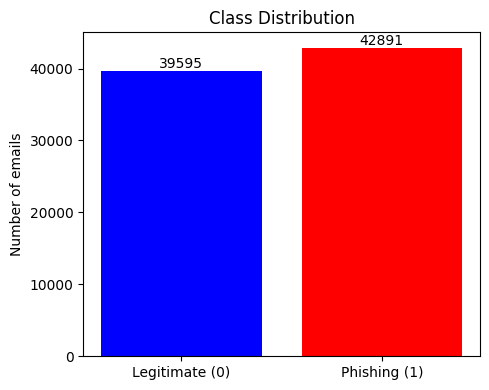

In [ ]:
# number of emails in each class is counted
label_counts = df['label'].value_counts().sort_index()

# bar chart is created for class distribution
plt.figure(figsize=(5, 4))
colors = ['blue', 'red']
plt.bar(['Legitimate (0)', 'Phishing (1)'], label_counts, color=colors)
plt.title('Class Distribution')
plt.ylabel('Number of emails')

# number of each class is added to their bar
for i, count in enumerate(label_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

From the plot it can be seen that there are **39595 legitimate emails** and **42891 phishing emails** in total. The class balance is quite even, which is good for the model to reduce chance of bias towards either class.


---



Few example **phishing** and **legitimate** emails are printed, with the **max length of 200** as a **cutoff point** for readability.

In [ ]:
print("Example legitimate emails:\n")
# first three legitimate emails are printed with max 200 characters
for text in df[df['label'] == 0]['text_combined'].head(3):
    print("-" * 200)
    print(text[:200])
    print()

print("\nExample phishing emails:\n")
# first three phishing emails are printed with max 200 characters
for text in df[df['label'] == 1]['text_combined'].head(3):
    print("-" * 200)
    print(text[:200])
    print()

Example legitimate emails:

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
hpl nom may 25 2001 see attached file hplno 525 xls hplno 525 xls

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
nom actual vols 24 th forwarded sabrae zajac hou ect 05 30 2001 12 07 pm enron capital trade resources corp eileen ponton 05 29 2001 08 37 davilal txu com cstonel txu com mjones 7 txu com hpl scheduli

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
enron actuals march 30 april 1 201 estimated actuals march 30 2001 flow march 31 2001 flow april 1 2

From the examples it can be seen that **legitimate emails** mostly look like internal business emails with schedule information, operational data, some file references, and some work terminology. They tend to look practical and related to certain incidences or contexts. There are dates, locations and numbers.

**Phishing emails**, on the other hand, have promotions, exaggerated claims, adverts for products, subcriptions, and messages try to be urgent or somehow make the reader curious.


---



The number of **duplicates** is checked based on the `text_combined` feature. The number of emails with identical text are then counted and the total percentage is printed.

In [ ]:
# count the number of duplicates in the text_combined column
duplicate_count = df.duplicated(subset=['text_combined']).sum()
# the percentage of duplicates in the whole dataset
print(f"\nDuplicate emails: {duplicate_count} ({duplicate_count / len(df) * 100:.2f}%)")

# print four examples with their features
if duplicate_count > 0:
    print("\nSample of duplicate email texts:")
    duplicates = df[df.duplicated(subset=['text_combined'], keep=False)].sort_values('text_combined')
    print(duplicates.head(4)[['text_combined', 'label']])


Duplicate emails: 408 (0.49%)

Sample of duplicate email texts:
                                          text_combined  label
1587   survive bid week hear lost another employee s...      0
1588   survive bid week hear lost another employee s...      0
8245   tani yes aware thanks letting know hr rep lon...      0
8244   tani yes aware thanks letting know hr rep lon...      0


There are in total **408 duplicate emails** that account for **0.49%** of the complete dataset. The example print shows that there are identical `text_combined` values with different pandas indices, proving that there are some duplicates in the combined dataset.



---


The distribution of **email lengths** for both **phishing** and **legitimate** emails are plotted. First, text length for every email's `text_combined` feature is calculated. **Outliers** are left out to not skew the plots too much, so the top **1%** of lengths are left out and the **99th percentile** is used. The remaining emails are plotted with **phishing emails** again in **red** and **legitimate** ones in **blue**. The plots are overlapped for easier comparison, and the **cutoff** is printed at the end.

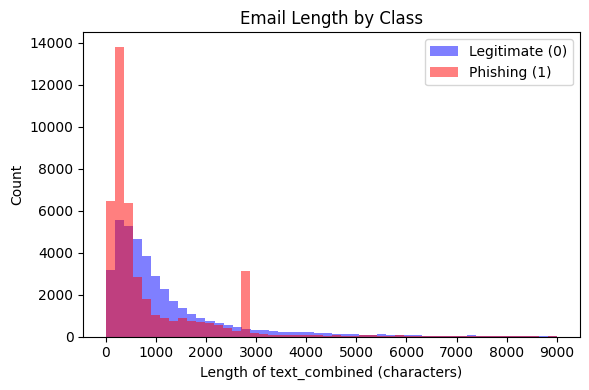

99th percentile cutoff: 9014.099999999919


In [ ]:
# calculate text lengths for every email's combined_text
df['text_length'] = df['text_combined'].str.len()
# calculate the 99th percentile length to remove 1% top outliers
cutoff = df['text_length'].quantile(0.99)
# only emails with length same or below the cutoff are kept
df_filtered = df[df['text_length'] <= cutoff]

# filtered lengths are separated based on class
legit_lengths = df_filtered[df_filtered['label'] == 0]['text_length']
phish_lengths = df_filtered[df_filtered['label'] == 1]['text_length']

# overlapping plots
plt.figure(figsize=(6, 4))
plt.hist(legit_lengths, bins=50, alpha=0.5, label='Legitimate (0)', color='blue')
plt.hist(phish_lengths, bins=50, alpha=0.5, label='Phishing (1)', color='red')
plt.title('Email Length by Class')
plt.xlabel('Length of text_combined (characters)')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(0, int(cutoff) + 1, 1000))
plt.tight_layout()
plt.show()

# the cutoff point is printed
print("99th percentile cutoff:", cutoff)

From the plot it can be seen that after removing the outliers above the **99th percentile** cutoff of **9014 characters**, it becomes clear that most of the **phishing emails** are short with a strong peak at approximately **300 characters** and another smaller peak at around **2700 characters**. The **legitimate emails** vary more in their lengths and are more evenly spread out in the plot, as real messages tend to be.

# Data Preparation

All the **408** duplicate entries in the dataset, which were identified in **data understanding**,  are removed based on identical `text_combined` features. Only the first entry is kept and the rest are removed.

In [ ]:
# remove duplicates from the dataset based on text_combined
df = df.drop_duplicates(subset=['text_combined'], keep='first').reset_index(drop=True)

print("Dataset size after removing duplicates:", len(df))
print("Duplicate count:", df.duplicated(subset=['text_combined']).sum())

Dataset size after removing duplicates: 82078
Duplicate count: 0


The dataset had **82486 entries** before, so the removal of **408 duplicates** should result in **82078 entries**. After removal of **408 duplicates** the output confirms that the dataset now contains **82078 entries** and **0 duplicates**.


---



The target `label` is set to variable `y` and rest of the features are set to `X`. The dataset is then split into training and test sets using **20%** for testing. The training set is further split into training and validation sets using **15%** for the validation set.

In [ ]:
# set target variable label as y
y = df['label']
# set input features as X by dropping target variable label
X = df.drop(columns=['label'])

# split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# split the training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)



---


Here a tokenizer is initialized based on the pretrained model **DistilBERT**. DistilBERT is pretrained on a general corpus, which contains data from Wikipedia and a collection of over 7000 books from different genres. Additionally, Distilbert is pretrained through a triple loss objective: language modelling loss, distillation loss, and cosine-distance loss. Overall, this gives it similar performance to large transformer language models from its time (2020).

We use a pretrained and -configured tokenizer because we want to incorporate words from a variety of contexts, as just work-context emails from a select few organizations and situations are likely lacking in this regard. Furthermore, sentence structures in emails, especially in scam variants, are funky, meaning creating tokens solely from them might not translate well to broader contexts. We want the model to generalize well, which we believe is more achievable using a pretrained model like DistilBERT.

The maximum sequence length is set to 256. This is very likely satisfactory for emails, as they are usually short.

In [ ]:
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 256



---


Here a custom dataset class is built for our phising-email dataset. Its parameters include input variables (texts), labels (target variables), the tokenizer, and the maximum sequence length. It has two built-in functions: one to withdraw the number of samples (__len__), and one to retrieve a specific sample by index (__getitem__).

In [ ]:
class EmailDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts['text_combined'].tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    # get number of samples
    def __len__(self):
        return len(self.texts)

    # get specific sample by index
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



---


Below three datasets are created: a training dataset, a validation dataset, and a test dataset.

In [ ]:
# create datasets
train_dataset = EmailDataset(X_train, y_train, tokenizer, max_length)
val_dataset = EmailDataset(X_val, y_val, tokenizer, max_length)
test_dataset = EmailDataset(X_test, y_test, tokenizer, max_length)

Here the datasets are transformed into dataloaders. This makes the dataset easily iterable by Pytorch. Additionally, batch sizes for training and evaluation are provided, and the training dataset is shuffled.

In [ ]:
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Modeling

This section covers the process of building and training the spam detection model using **DistilBERT**.




---

Modeling begins with the findings from experimenting with different model configurations and number of unfrozen transformer layers.

The following table contains all the different experimentations (labeled **A-F**) with different number of trainable (unfrozen) layers (**0-2**). It also includes the information of learning rate scheduler, and the type of colab model used (**A100**, **L4**). The best performing model configuration will be chosen as the final model.

---

| Experiment | Trainable Layers | LR / Scheduler            | Early Stop | Epochs Run | Best Epoch | Val Acc | Val Loss | Time / Epoch (GPU) | Total Time |
|-----------|------------------|---------------------------|------------|------------|------------|---------|----------|--------------------|------------|
| A         | 2                | 5e-5                      | No         | 10         | 5          | 0.9937  | 0.0172   | ~3:54 (A100)       | ~39 min    |
| B         | 1                | 5e-5                      | No         | 10         | 8          | 0.9923  | 0.0253   | ~3:29 (A100)       | ~35 min    |
| C         | 2                | 1e-5                      | Yes        | 4          | 3          | 0.9890  | 0.0300   | ~3:52 (A100)       | ~11.5 min  |
| D: ReduceLROnPlateau        | 2                | 5e-5 → 5e-6    | Yes        | 7          | 4          | 0.9933  | 0.0222   | ~4:02 (A100)       | ~28 min    |
| E: ReduceLROnPlateau, Rerun of D        | 2                | 5e-5 → 5e-6    | Yes        | 11         | 8          | 0.9939  | 0.0209   | ~6:23 (L4 GPU)     | ~70 min    |
| F: ReduceLROnPlateau        | 0                | 5e-5                      | Yes        | 10         | 10         | 0.9683  | 0.0813   | ~3:00               | ~30 min    |


---

The are **6** experiments with different configurations. The difference between experiments was the number of trainable transformer layers in **DistilBERT**. The top hidden layer and the classification head are always trainable. For the different experiments the training had the tendency to peak at **4**/**5th** epoch, which resulted in overfitting or very miniscule benefits beyond that point. Reduction in learning rate didn't help improve the performance or the have an effect on the training time. As a callback, early stopping with restoration of the best model weights prevented unnecessary training and helped reduce overfitting.

The most important factor affecting the performance was the number of trainable layers, even though all three different configurations performed exceptionally well. No more than **2** trainable layers were experimented with, as the model had already achieved an accuracy above **99%** and small validation loss with **2** trainable layers. Every additional trainable layer greatly increased the training time making further experimentation impractical.

Configuration **E** was chosen as the final model as it performed the best out of the different experiments. **2** trainable layers proved to be the optimal amount for performance and trainability, this was further supported by other sources that had been experimenting with different number of trainable layers in **DistilBERT**.

## The Final Model
To ensure the model and data are on the same hardware, the computing device must be explicitly defined. If a CUDA-compatible GPU is available, it is selected. Else, CPU is selected.

In [ ]:
# define device to load model on as CUDA if available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


## Model configuring

The pre-trained **DistilBERT** model is loaded using **PyTorch** and the Hugging Face library. A classification head is configured for **two classes** (spam and ham).

### Freezing layers

To reduce training time, the first **five** layers of DistilBERT are frozen.

The remaining layers stay trainable. These are:
- The last **two transformer** layers
- A **pre-classifier** layer
- The final **classifier** layer

### Model architecture

The model has **three** main components:

1. A **DistilBERT core**, which forms the foundation of the model. It begins with an **embeddings layer** that converts each token into a 768-dimensional vector. This layer combines two types of embeddings: word embeddings (vocabulary of **30522 tokens**) and positional embeddings (sequence length of **512**). The word embeddings capture the meaning of the token, and positional embeddings represent where each token appears in the sequence, allowing the model to understand word order. Layer normalization and dropout are applied to stabilize the combined result.

    The embeddings feed into a **transformer** consisting of **six transformer blocks** (layers 0-5). Each transformer block contains several components that together process the input:
    
    - Multi-head self-attention mechanism with four fully connected (linear) layers to determine which tokens are most relevant to each other
    - Layer normalization to stabilize values
    - Feed-forward network with two fully connected layers (768 -> 3072 -> 768) with GELU activation. Expanding to 3072 dimensions gives the model more space to capture complex patterns before compressing back to 768 dimensions
    - Dropout for regularization

2. A **pre-classifier** receives the 768-dimensional output from the final transformer block and applies another fully connected layer (768 -> 768) with dropout. This layer helps the model adjust the output specifically for spam detection, even though the vector size stays the same.

3. A fully connected **classifier** layer, that transforms the 768-dimensional vector into **two output scores** (logits). These scores indicate the model's predictions for each class, where the higher score determines the predicted class. These logits are later converted to probabilities by the loss function during training.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# define all DistilBERT layers
DISTILBERT_LAYERS = ['embedding', 'transformer.layer.0', 'transformer.layer.1', 'transformer.layer.2', 'transformer.layer.3', 'transformer.layer.4', 'transformer.layer.5']
# choose which layers are frozen and freeze them
frozen_layers = DISTILBERT_LAYERS[:5]
for frozen_layer_name in frozen_layers:
    for layer_name, layer_params in model.named_parameters():
        if frozen_layer_name in layer_name:
            layer_params.requires_grad = False
# load model on device
model.to(device)

The optimizer and loss functions are configured next as a setup for the training.

**AdamW** (Adam with Weight Decay) is used as the optimizer instead of Adam. This is because AdamW handles weight decay (regularization) more effectively, preventing overfitting better than Adam.

The learning rate is set to **5e-5** (0.00005), which prevents drastic adjusting of the pre-trained weights that DistilBERT has already learnt. The `filter(lambda p: p.requires_grad, model.parameters())` ensures that parameters that are marked as trainable are updated only.

Although the dataset has only two classes, **categorical cross-entropy** is used instead of binary cross-entropy. DistilBERT outputs one score per class, while binary cross-entropy expects a single probability. To use binary cross-entropy, DistilBERT's output layer would need to be modified.

In [ ]:
# optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

## Train epoch function

The `train_epoch()` function covers **one** complete pass through the entire training set and returns two metrics: **average loss and accuracy**.

### Parameters

The function accepts **five** parameters that control the training process: the DistilBERT model, PyTorch DataLoader, optimizer, criterion and device.

### Setup

The model is set to training mode using `model.train()`.

**Three** variables are initialized to track performance throughout the epoch.
- `total_loss` accumulates the loss values from each batch
- `correct` variable tracks how many predictions match their true labels
- `total` counter tracks how many samples have been processed

### Loop

The core of the function is a **loop** that processes each batch of emails.

#### Step 1: Move data

Each batch contains **three** components that must be moved to the computing device:
- `input_ids` tensor contains the tokenized emails
- `attention_mask` tensor indicates which tokens to process (to ignore padding)
- `labels` tensor contains the real classifications (0 = legitimate, 1 = spam)

#### Step 2: Reset gradients

`optimizer.zero_grad()` resets gradients form the previous batch. Without this, the values would add up across batches, causing incorrect weight updates.

#### Step 3: Forward pass

The **forward pass** sends the data through the layers and processes the tokenized text, considers the attention mask, and produces predictions.

The output is stored in `outputs.logits`, containing **two** scores per email: the first value is the score for legitimate, and the second for spam. These are just scores (not probabilities), where higher values indicate stronger predictions.

#### Step 4: Calculate loss

The `CrossEntropyLoss` measures how **wrong** the predictions are. It applies softmax to convert the logits into probabilities that sum to 1. Then it uses the true label to select the corresponding probability, and takes the negative logarithm of that probability.

#### Step 5: Backward pass

`loss.backward()` uses **backpropagation** to calculate gradients, indicating how much each weight contributed to the error and in which direction to adjust that weight.

#### Step 6: Update weights

The `optimizer.step()` **updates** the model's weights to reduce loss.

#### Step 7: Update metrics

After adjusting the model, the performance metrics are updated:

- The **batch loss** is added to the running total with `loss.item()`, which converts the PyTorch tensor to a regular number
- The logits are converted to actual **predictions** with `torch.argmax(outputs.logits, dim=1)`, which finds which class has the higher score
- `(predictions == labels).sum().item()` compares the predictions to their true labels and counts how many predictions were **correct**
- `labels.size(0)` gives the batch size, which is added to the total number of predictions **processed**

#### Final calculations

When all batches have been processed, the **average loss** and **accuracy** statistics are calculated for the entire epoch.

In [ ]:
# training function
def train_epoch(model, dataloader, optimizer, criterion, device):

    model.train() # set mode as training

    # tracking variables
    total_loss = 0
    correct = 0 # number of correct predictions
    total = 0 # number of samples processed

    for batch in tqdm(dataloader, desc="Training"):
        # move data to selected device
        input_ids = batch['input_ids'].to(device) # tokenized text
        attention_mask = batch['attention_mask'].to(device) # which tokens to pay attention to
        labels = batch['labels'].to(device) # true labels

        # reset gradients
        optimizer.zero_grad()

        # pass the data through the model
        # model processes the input and produces predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # calculate loss
        loss = criterion(outputs.logits, labels)

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update tracking variables
        total_loss += loss.item() # add batch loss to running total
        predictions = torch.argmax(outputs.logits, dim=1) # determine which class is predicted
        correct += (predictions == labels).sum().item() # count how many predictions match their true labels
        total += labels.size(0) # count how many emails have been processed

    # calculate final metrics for the epoch
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

## Evaluate function

The `evaluate()` function measures model performance on the **validation set** for **one** complete pass trough the data **without** updating weights. It accepts the same parameters as `train_epoch()` except for the optimizer (as no training occurs).

### Differences to training

The function has **two** major differences:

1. `model.eval()` disables dropout and uses learnt statistics for batch normalization.
2. The loop runs through `with torch.no_grad()`, disabling gradient computation.

### Structure

The loop follows the same structure as training, however, gradient reset, backpropagation, and weight updates are skipped since the model isn't learning.

### Output

Like `train_epoch()`, the function returns **average loss and accuracy** calculated across all batches in the epoch.

In [ ]:
# evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval() # set model to evaluating mode

    # tracking variables
    total_loss = 0
    correct = 0 # number of correct predictions
    total = 0 # number of samples processed

    # disable gradient computation
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # move data to selected device
            input_ids = batch['input_ids'].to(device) # tokenized text
            attention_mask = batch['attention_mask'].to(device) # which tokens to pay attention to
            labels = batch['labels'].to(device) # true labels

            # pass the data through the model
            # model processes the input and produces predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # calculate loss
            loss = criterion(outputs.logits, labels)

            # update tracking variables
            total_loss += loss.item() # add batch loss to running total
            predictions = torch.argmax(outputs.logits, dim=1) # determine which class is predicted
            correct += (predictions == labels).sum().item() # count how many predictions match their true labels
            total += labels.size(0) # count how many emails have been processed

    # calculate final metrics for the epoch
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total

    return avg_loss, accuracy

## Training loop

The training loop is how the model learns. It runs up to **20** epochs, where each epoch trains the model on the entire training set, and evaluates its performance on the validation set.

### Performance tracking

A `history` dictionary saves four performance metrics after each epoch to track progress: training loss and accuracy, as well as validation loss and accuracy.

### Early stopping

**Early stopping** stops the training if validation loss doesn't improve for **3** consecutive epochs.

### Learning rate scheduling

`ReduceLROnPlateau` is used to adjust learning rate if the validation loss doesn't increase for **1** epoch.

### Training progress

During each epoch:

1. The model is trained on the training set using `train_epoch()`
2. The performance is evaluated on the evaluation set using `evaluate()`
3. The scheduler adjusts learning rate if needed
4. The perfromance metrics are saved to the history dictionary
5. The results are displayed
6. The validation loss is checked for improvements: if improved, the model continues training, else, the training is stopped if it's the 3rd consecutive epoch without improvements

### After training

After training, the model is restored to the version that achieved the lowest validation loss during training.

In [ ]:
# training loop
num_epochs = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# variables to determine early stopping
val_loss_best = float('inf') # best validation loss seen so far
best_version = None # model state when best validation loss was achieved
no_improvements = 0 # count epochs with no improvement
early_stop_threshold = 3

# create reduce learning rate on plateau scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, min_lr=5e-8)

for epoch in range(num_epochs):
    # display progress
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Learning rate: {scheduler.get_last_lr()[0]}")

    # train and validate
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # adjust learning rate based on validation loss
    scheduler.step(metrics=val_loss)

    # record metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # display results
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # check if validation loss improved
    if val_loss >= val_loss_best:
        # no improvement
        no_improvements += 1
        if no_improvements >= early_stop_threshold:
            print("Early stopping...")
            break
    else:
        # improved, save as best version
        no_improvements = 0
        val_loss_best = val_loss
        best_version = model

# restore best version of model
model = best_version


Epoch 1/20
Learning rate: 5e-05


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.57it/s]


Train Loss: 0.0916, Train Acc: 0.9648
Val Loss: 0.0310, Val Acc: 0.9885

Epoch 2/20
Learning rate: 5e-05


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.53it/s]


Train Loss: 0.0312, Train Acc: 0.9887
Val Loss: 0.0237, Val Acc: 0.9917

Epoch 3/20
Learning rate: 5e-05


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.52it/s]


Train Loss: 0.0188, Train Acc: 0.9930
Val Loss: 0.0312, Val Acc: 0.9885

Epoch 4/20
Learning rate: 5e-05


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.54it/s]


Train Loss: 0.0124, Train Acc: 0.9954
Val Loss: 0.0249, Val Acc: 0.9920

Epoch 5/20
Learning rate: 5e-06


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.56it/s]


Train Loss: 0.0041, Train Acc: 0.9988
Val Loss: 0.0205, Val Acc: 0.9940

Epoch 6/20
Learning rate: 5e-06


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.55it/s]


Train Loss: 0.0030, Train Acc: 0.9991
Val Loss: 0.0216, Val Acc: 0.9943

Epoch 7/20
Learning rate: 5e-06


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.50it/s]


Train Loss: 0.0019, Train Acc: 0.9993
Val Loss: 0.0243, Val Acc: 0.9939

Epoch 8/20
Learning rate: 5.000000000000001e-07


Evaluating: 100%|██████████| 616/616 [00:39<00:00, 15.47it/s]

Train Loss: 0.0014, Train Acc: 0.9996
Val Loss: 0.0228, Val Acc: 0.9941
Early stopping...


# Evaluation
This section will cover the performance of the fine-tuned **DistilBERT** model.

The training history is visualized by plotting the accuracy and loss for both the training and validation sets. From the plots we can observe important indicators, such as possible signs of overfitting, if the training loss continues to decrease while validation loss stops improving.

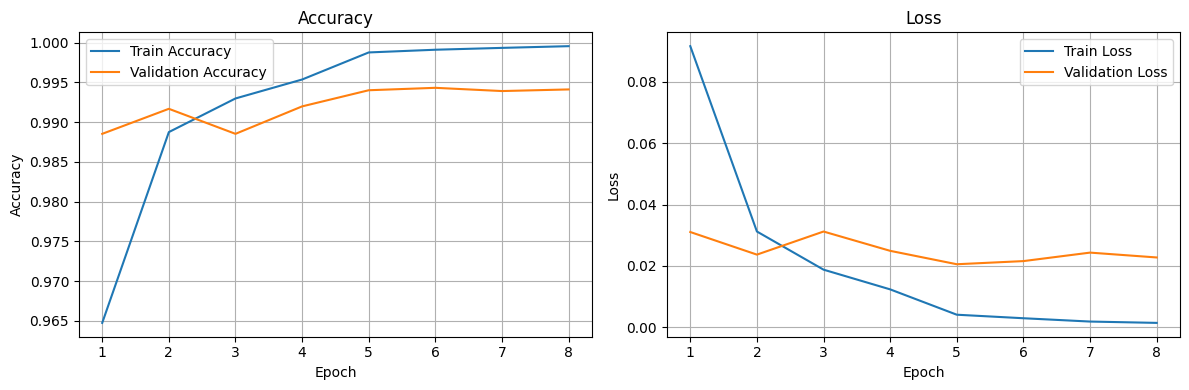

In [ ]:
plt.figure(figsize=(12, 4))

# plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, len(history['train_acc']) + 1), history['train_acc'], label='Train Accuracy')
plt.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# plot for loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], label='Train Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The **accuracy** and **loss curves** show that the model's training is stable and efficient.

Both the training and validation **accuracy** improve steadily, starting around **0.96-0.98** and reaching **0.99-1.00**. The two curves stay close to each other throughout training, which is a good indicator that the model is _not_ overfitting. **Validation accuracy** is only slightly below **training accuracy** in later epochs, suggesting that the model generalizes well and that the validation set is similar in difficulty to the training set.

**Training** and **validation loss** decrease smoothly and consistently. The **training loss** starts higher but drops quickly, and **validation loss** follows a similar pattern. There is only a small separation between the curves, no plateaus, and no significant peaks in **validation loss**. This indicates **no signs of overfitting**.

Overall, the model clearly learns meaningful connections from the data. Performance indicates that the chosen hyperparameters, dataset, and number of epochs were appropriate, and that the model learned the phishing classification task effectively.


---



Next, after verifying that training proceeded sensibly, we evaluate the model on the held-out test set.

In [ ]:
def test(model, dataloader, criterion, device):
    model.eval() # set model to evaluating mode
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            total_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy, all_labels, all_preds

In [ ]:
# final evaluation on test set and store labels and predictions for confusion matrix
test_loss, test_acc, labels, predictions = test(model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 1026/1026 [01:21<00:00, 12.63it/s]


Test Loss: 0.0256, Test Accuracy: 0.9943


The model achieves a test **accuracy of 99.43%** with a test **loss of 0.0256**, which indicates strong generalization to unseen emails. The low loss value shows that the model is not only making correct predictions, but also making them with confidence.


---



Next, we'll investigate what kind of mistakes the model makes. To gain that understanding, we examine the confusion matrix. Each cell of the matrix reflects how often the model predicted a class correctly or incorrectly.

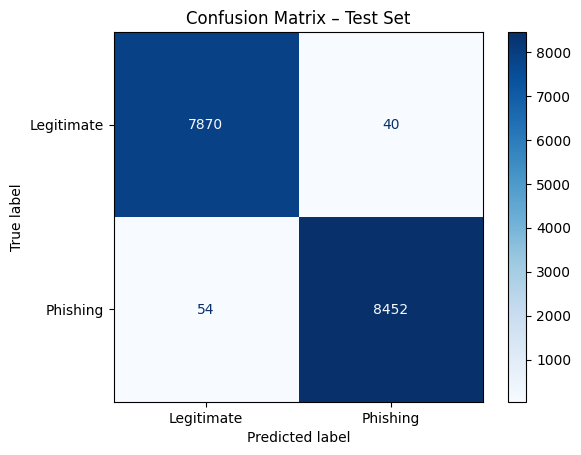

In [ ]:
# compute confusion matrix
cm = confusion_matrix(labels, predictions)

# display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legitimate", "Phishing"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Test Set")
plt.show()

**The confusion matrix** shows that the model performs very well on both classes.

Out of **7910** legitimate emails, the model correctly identifies **7870** of them. Only **40** legitimate emails are incorrectly flagged as phishing. Out of **8506** phishing emails, the model correctly classifies **8452** of them. It misclassifies **54** phishing emails as legitimate. Although this is a very small amount relative to the total, these **false negatives** are the more critical error in a security context, since missed phishing attempts could reach users. However, the false negative rate here is extremely low.

Overall, the matrix confirms that the model is **accurate and performs well**, successfully distinguishing between phishing and legitimate emails with few mistakes.

## Attention Score Heatmap

An attention score heatmap is used to vizualize how strong the connections between tokens are based on attention scores.


---

To prepare the data it is tokenized and moved to the right device, the model is then run in inference mode with attention outputs on, which will then enable the extraction of attention weights from the transformer layers.

In [ ]:
# input data from tokenizer
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# forward pass with attention output enabled
with torch.no_grad(): # no gradient calculation for inference
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_attentions=True,
        return_dict=True
    )

# get the attention weights
attention_weights = outputs.attentions

Prepare attention matrix for final layer. The attention matrix is prepared for the final layer by extracting attention from one transformer layer and it is used to average across all the heads. Removing padding and creating a token pair attention matrix.

In [ ]:
layer_index = 5
layer_attention = attention_weights[layer_index]

# squeeze the batch dimension
layer_attention = layer_attention.squeeze(0)

# average across all 12 heads
averaged_attention = layer_attention.mean(dim=0)

# convert to a NumPy array for easier plotting
attention_matrix = averaged_attention.cpu().numpy()

# find the length of the non-padded sequence
seq_len = torch.sum(attention_mask[0]).item()

# crop the matrix
cropped_matrix = attention_matrix[:seq_len, :seq_len]

The attention score heatmap is displayed using seaborn.

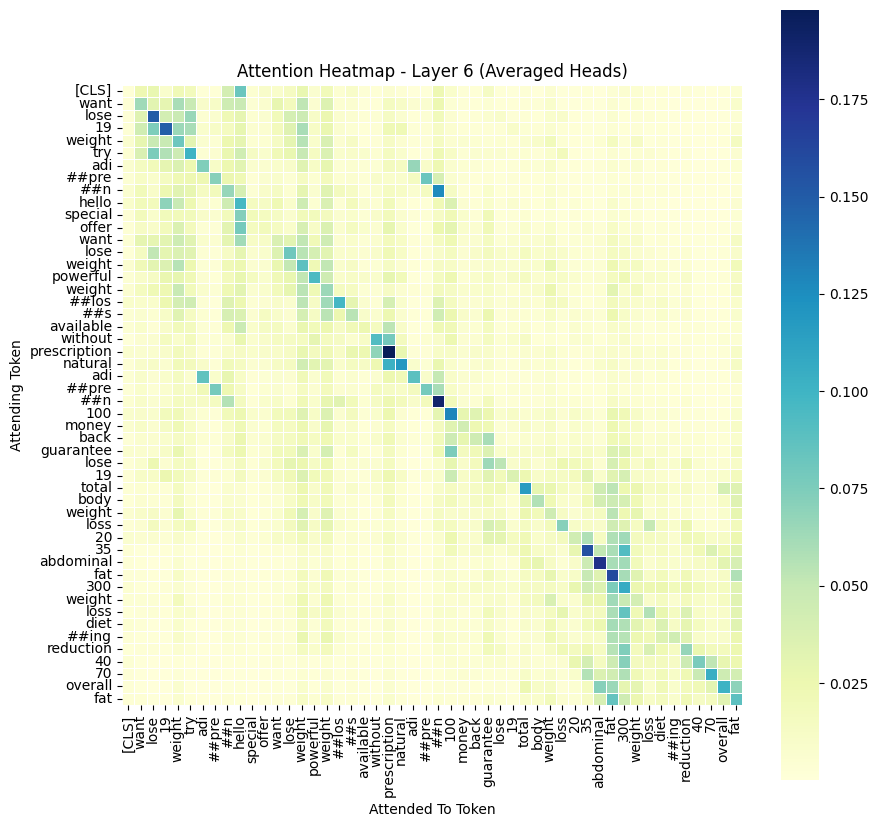

In [ ]:
import seaborn as sns

sub_length = 50
cropped_matrix = cropped_matrix[:sub_length, :sub_length]

# get the list of tokens for axis labels
tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())[:sub_length]

plt.figure(figsize=(10, 10))
# plot the heatmap
sns.heatmap(
    cropped_matrix,
    xticklabels=tokens,
    yticklabels=tokens,
    cmap="YlGnBu",
    linewidths=0.5,
    square=True
)
plt.title(f'Attention Heatmap - Layer {layer_index + 1} (Averaged Heads)')
plt.ylabel('Attending Token')
plt.xlabel('Attended To Token')
plt.show()

The attention heatmap from the transformer layer 6 shows how tokens in an email trying to advertise weight loss products connect to each other.

The diagonal shows the connection of the words to themselves and the nearby fainter blue colors represent the nearby words in the sequence. Not very interpretable connections can be drawn from the heatmap except some related words for weight loss. There seems to be some slight patterns maybe forming that would indicate connection between words used for marketing a weight loss item. Overall it is very hard to draw any real conclusions from the heatmap alone and proves to be just an interesting visualization.


---



The top K highest attention scores are found that are not the token itself. This shows which tokens strongly connect with other tokens in the transformer layer.

In [ ]:
K = 50
print(f"\n--- Top {K} Dissimilar Attention Scores (i ≠ j) from Layer {layer_index} ---")

flat_matrix = cropped_matrix.flatten()
# get the top K highest attention scores between token pairs
top_k_flat_indices = np.argsort(flat_matrix)[-K:][::-1]

# get the top K scores
top_k_scores = flat_matrix[top_k_flat_indices]

# convert flat indices to 2D coordinates
row_indices, col_indices = np.unravel_index(top_k_flat_indices, (sub_length, sub_length))

# create a boolean mask to filter out pairs where i == j
dissimilar_mask = row_indices != col_indices

# use the mask on all calculated arrays
dissimilar_row_indices = row_indices[dissimilar_mask]
dissimilar_col_indices = col_indices[dissimilar_mask]
dissimilar_scores = top_k_scores[dissimilar_mask]

# print the results table with only the filtered pairs
max_display = min(K, len(dissimilar_scores))

print(f"Found {len(dissimilar_scores)} dissimilar pairs in the top {K} results.")
print("| Rank | Score | Attending Token (i) | Attended Token (j) |")
print("|------|-------|---------------------|--------------------|")

for rank in range(max_display):
    i = dissimilar_row_indices[rank]
    j = dissimilar_col_indices[rank]
    score = dissimilar_scores[rank]

    # get the tokens
    attending_token = tokens[i]
    attended_token = tokens[j]

    # print the result
    print(f"| {rank + 1:<4} | {score:.4f} | {attending_token:<19} | {attended_token:<18} |")


--- Top 50 Dissimilar Attention Scores (i ≠ j) from Layer 5 ---
Found 22 dissimilar pairs in the top 50 results.
| Rank | Score | Attending Token (i) | Attended Token (j) |
|------|-------|---------------------|--------------------|
| 1    | 0.1262 | ##n                 | ##n                |
| 2    | 0.1023 | natural             | prescription       |
| 3    | 0.0921 | 35                  | 300                |
| 4    | 0.0861 | adi                 | adi                |
| 5    | 0.0857 | loss                | 300                |
| 6    | 0.0846 | fat                 | fat                |
| 7    | 0.0823 | ##pre               | ##pre              |
| 8    | 0.0821 | [CLS]               | hello              |
| 9    | 0.0785 | without             | prescription       |
| 10   | 0.0779 | ##pre               | ##pre              |
| 11   | 0.0777 | offer               | hello              |
| 12   | 0.0758 | try                 | lose               |
| 13   | 0.0755 | guarantee       

The list shows the tokens that strongly connect to a different token where **i ≠ j**, in the transformer layer **6** (wrongly shown as layer 5 in print). The top **50** scores show that **22** pairs are connections between tokens that aren't themselves. The reason same word or subword can show on both sides of the pair is because same token can show up several times at different positions of the input sequence.

The high scoring pairs have connections that can be thought to belong to or associated with phishing attempt or spam. These words inlcude `lose/loss`, `fat`, `prescription`, `guarantee`, and numbers that are related to claims and offers. This shows that the model is able to form connections based on semantics  between some tokens. In conclusion the result shows that **DistilBERT**'s deeper layer can capture connections between tokens that relate to promotional language and some numbers used for claims of effectiviness etc.

### Final evaluation
The overall results show that the **fine-tuned DistilBERT** model performs strongly on the phishing classification task. The **training** and **validation** curves developed in a steady and consistent way, with accuracy rising and loss decreasing throughout. Because the validation trends closely followed the training trends, there is **no clear sign of overfitting**, and the model appears to have learned the task reliably.

The final test evaluation supports this. Achieving a test accuracy of **99.43%** and a low test loss of **0.0256** indicates that the model generalizes well to new, unseen emails. The performance on the test set aligns closely with what was observed during validation, suggesting that the model's behavior is stable across different data splits.

**The confusion matrix** provides a more detailed view of the model's behaviour. It shows that the classifier correctly identifies the majority of both legitimate and phishing emails, with only small numbers of incorrect predictions. Most legitimate emails are recognized as legitimate, and most phishing emails are detected correctly. The number of missed phishing emails is relatively low, which is especially important in a security-focused task like this. At the same time, the model does not produce too many false alarms by misclassifying legitimate emails as phishing.

All together, these results show that the model is both accurate and dependable. Its learning behaviour is stable, its performance on unseen data is strong, and its pattern of mistakes is limited and well-distributed. The classifier is therefore well-suited for practical use in detecting phishing emails, with only minor areas left for potential improvement. Future improvements could include incorporating additional **email-level signals**, such as **URL reputation**, **sender domain characteristics**, or **header anomalies**, which can help the model detect more subtle or sophisticated phishing attempts.


---



Save the weights only for future inference.

In [ ]:
# save the model for future inference
PATH = './email_classifier.pt'
torch.save(model.state_dict(), PATH)

# Deployment

A new **DistilBERT** model is created with the classification head so that the trained weights can be loaded into it. An empty model is built as a dummy with the same architecture as the trained one.

In [ ]:
model_name = "distilbert-base-uncased"
num_labels = 2

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




---


The saved model weights `state_dict` are loaded and used with the dummy DistilBERT model. This way the the fine tuned parameters are loaded and the model works like the trained one.

In [ ]:
state_dict = torch.load(PATH)
model.load_state_dict(state_dict)

<All keys matched successfully>



---


The tokenizer for **DistilBERT** is loaded so input text can be converted to tokens that are ready for the model. Device is chosen as **CUDA**(GPU) if available otherwise **CPU**.

In [ ]:
from transformers import AutoTokenizer

# initialize the tokenizer with the same model name
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# device and label map
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

label_map = {0: "Legit", 1: "Scam"}



---


The `preprocess_text` function preprocesses the raw text for **DistilBERT**. The tokenizer converts the input into token IDs and an attention mask, adds padding and truncation if needed. The tensors gained as a result are then moved to the right device.

In [ ]:
def preprocess_text(text: str, tokenizer, device):
    # tokenize the text
    inputs = tokenizer(
        text,
        return_tensors="pt", # return pytorch tensors
        padding=True,
        truncation=True
    )

    # tensors moved to the model's device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    return input_ids, attention_mask

# example input text
input_text = "BEEP BEEP THIS IS NOT A SCAM BEEP BOOP!"
input_ids, attention_mask = preprocess_text(input_text, tokenizer, device)



---


The `get_prediction` function runs the model with evaluation mode and returns the raw output scores (logits). To speedup the process no gradients are calculated.

In [ ]:
def get_prediction(model, input_ids, attention_mask):
    model.eval() # model in evaluation mode

    with torch.no_grad():
        # input passed to the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        return logits

# raw scores
logits = get_prediction(model, input_ids, attention_mask)



---


The models output is made into a final prediction and **Softmax** is used to turn the raw scores into class probabilities. The class that has the highest prediction is chosen and its confidence score is also stored. The input text and rest of the information are then output.

In [ ]:
# convert logits to probabilities with softmax
probabilities = torch.softmax(logits, dim=1) # dim=1 is the class dimension

# get the predicted class index
predicted_index = torch.argmax(probabilities, dim=1).item()

# get the probability of the predicted class
confidence_score = probabilities[0, predicted_index].item()

# map the index to to a label
predicted_label = label_map[predicted_index]

print(f"Input Text: \"{input_text}\"")
print("-" * 30)
print(f"Raw Logits: {logits.cpu().numpy().round(3)}")
print(f"Probabilities: {probabilities.cpu().numpy().round(3)}")
print(f"Predicted Class: **{predicted_label}**")
print(f"Confidence: **{confidence_score:.4f}**")

Input Text: "BEEP BEEP THIS IS NOT A SCAM BEEP BOOP!"
------------------------------
Raw Logits: [[-1.54   1.352]]
Probabilities: [[0.053 0.947]]
Predicted Class: **Scam**
Confidence: **0.9474**


The example input of "BEEP BEEP THIS IS NOT A SCAM BEEP BOOP!" is given a probability of **94.7%** of belonging to the class **phishing** compared to just **5.3%** of being legitimate. Therefore the chosen class is **phishing** with a far greater confidence. The logits already show that the latter value of **1.3521** for phishing is much higher than **-1.54** for legitimate. This shows that the model is able to convert raw outputs to understandable and interpretable probabilites and a binary prediction.


---



The saved model can already be used for classifying entirely new text as phishing or legitimate. In the future, the model could be integrated into an automatic email checker. This would be helpful for normal people in their daily lives, but also for organizations, as they could use the checker as a tool to improve their own information security by informing employees of suspicious emails.